## Import Statements

In [ ]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_1samp
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from PIL import Image

## Loading Datasets

In [3]:
def load_images(image_folder):
    images = []
    filenames = []
    for file in os.listdir(image_folder):
        try:
            if file.endswith('.dcm.png'):  # Adjust based on your image format
                img = load_img(os.path.join(image_folder, file), target_size=(224, 224))
                images.append(img_to_array(img))
                filenames.append(file)
        except Exception as e:
            print(f"Error loading image {file}: {e}")
    return images, filenames

# Set the correct path to your image folder
image_folder = '/Users/jayat/Desktop/project/images'
images, filenames = load_images(image_folder)

print(f"Loaded {len(images)} images.")

Loaded 7470 images.


In [4]:
# Load the report and projection data
reports_df = pd.read_csv('/Users/jayat/Desktop/project/indiana_reports.csv')
projections_df = pd.read_csv('/Users/jayat/Desktop/project/indiana_projections.csv')

## Data Pre-Processing

In [5]:
# Missing values
reports_df['findings'].fillna(method='ffill', inplace=True)
column_to_check = 'impression'
reports_df = reports_df.dropna(subset=[column_to_check])

In [25]:
# Grouping the projection data by UID and creating lists of filenames for frontal and lateral projections
aggregated_projections_df = projections_df.groupby('uid').agg({
    'filename': list,
    'projection': list
}).reset_index()

# Separate frontal and lateral projections into two columns
aggregated_projections_df['projection_frontal'] = aggregated_projections_df.apply(lambda row: [fname for fname, proj in zip(row['filename'], row['projection']) if proj == 'Frontal'], axis=1)
aggregated_projections_df['projection_lateral'] = aggregated_projections_df.apply(lambda row: [fname for fname, proj in zip(row['filename'], row['projection']) if proj == 'Lateral'], axis=1)

# Merge with the reports DataFrame
merged_df = pd.merge(reports_df, aggregated_projections_df[['uid','filename', 'projection_frontal', 'projection_lateral']], on='uid', how='inner')

In [26]:
merged_df

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection_frontal,projection_lateral
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"[1_IM-0001-4001.dcm.png, 1_IM-0001-3001.dcm.png]",[1_IM-0001-4001.dcm.png],[1_IM-0001-3001.dcm.png]
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,"[2_IM-0652-1001.dcm.png, 2_IM-0652-2001.dcm.png]",[2_IM-0652-1001.dcm.png],[2_IM-0652-2001.dcm.png]
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,Borderline cardiomegaly. Midline sternotomy XX...,"No displaced rib fractures, pneumothorax, or p...","[3_IM-1384-1001.dcm.png, 3_IM-1384-2001.dcm.png]",[3_IM-1384-1001.dcm.png],[3_IM-1384-2001.dcm.png]
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,"[4_IM-2050-1001.dcm.png, 4_IM-2050-2001.dcm.png]",[4_IM-2050-1001.dcm.png],[4_IM-2050-2001.dcm.png]
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,"[5_IM-2117-1003002.dcm.png, 5_IM-2117-1004003....",[5_IM-2117-1003002.dcm.png],[5_IM-2117-1004003.dcm.png]
...,...,...,...,...,...,...,...,...,...,...,...
3815,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...,"[3995_IM-2046-1001.dcm.png, 3995_IM-2046-2001....",[3995_IM-2046-1001.dcm.png],[3995_IM-2046-2001.dcm.png]
3816,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,"[3996_IM-2047-1001.dcm.png, 3996_IM-2047-3001....",[3996_IM-2047-1001.dcm.png],[3996_IM-2047-3001.dcm.png]
3817,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.","[3997_IM-2048-1001.dcm.png, 3997_IM-2048-1002....",[3997_IM-2048-1001.dcm.png],[3997_IM-2048-1002.dcm.png]
3818,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,"Heart size within normal limits. Small, nodula...",Heart size is normal and the lungs are clear.,"[3998_IM-2048-1001.dcm.png, 3998_IM-2048-1002....",[3998_IM-2048-1001.dcm.png],[3998_IM-2048-1002.dcm.png]


In [27]:
# Handle missing values
merged_df.fillna("", inplace=True)

# Combine relevant columns to form captions
merged_df['caption'] = merged_df['findings'] + " " + merged_df['impression']

# Defining the function to clean text by removing 'XXXX'
def clean_text(text):
    # Ensure that text is a string
    if not isinstance(text, str):
        return text
    # Remove 'XXXX' occurrences
    return text.replace('XXXX', '')

# List of columns you want to clean.
columns_to_clean = ['caption']

# Apply the clean_text function to each specified column
for column in columns_to_clean:
    if column in merged_df.columns:
        merged_df[column] = merged_df[column].apply(clean_text)

# Tokenize captions
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
tokenizer.fit_on_texts(merged_df['caption'])
sequences = tokenizer.texts_to_sequences(merged_df['caption'])

print("Preprocessing complete!")

Preprocessing complete!


In [28]:
merged_df

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection_frontal,projection_lateral,caption
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,"[1_IM-0001-4001.dcm.png, 1_IM-0001-3001.dcm.png]",[1_IM-0001-4001.dcm.png],[1_IM-0001-3001.dcm.png],The cardiac silhouette and mediastinum size ar...
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,"[2_IM-0652-1001.dcm.png, 2_IM-0652-2001.dcm.png]",[2_IM-0652-1001.dcm.png],[2_IM-0652-2001.dcm.png],Borderline cardiomegaly. Midline sternotomy . ...
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a , steps this . Pain to R ba...",,Borderline cardiomegaly. Midline sternotomy . ...,"No displaced rib fractures, pneumothorax, or p...","[3_IM-1384-1001.dcm.png, 3_IM-1384-2001.dcm.png]",[3_IM-1384-1001.dcm.png],[3_IM-1384-2001.dcm.png],Borderline cardiomegaly. Midline sternotomy . ...
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest , at hours",-year-old with .,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,"[4_IM-2050-1001.dcm.png, 4_IM-2050-2001.dcm.png]",[4_IM-2050-1001.dcm.png],[4_IM-2050-2001.dcm.png],There are diffuse bilateral interstitial and a...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,"[5_IM-2117-1003002.dcm.png, 5_IM-2117-1004003....",[5_IM-2117-1003002.dcm.png],[5_IM-2117-1004003.dcm.png],The cardiomediastinal silhouette and pulmonary...
...,...,...,...,...,...,...,...,...,...,...,...,...
3815,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.",", .",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...,"[3995_IM-2046-1001.dcm.png, 3995_IM-2046-2001....",[3995_IM-2046-1001.dcm.png],[3995_IM-2046-2001.dcm.png],The cardiomediastinal silhouette and pulmonary...
3816,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,"[3996_IM-2047-1001.dcm.png, 3996_IM-2047-3001....",[3996_IM-2047-1001.dcm.png],[3996_IM-2047-3001.dcm.png],The lungs are clear. Heart size is normal. No ...
3817,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.","[3997_IM-2048-1001.dcm.png, 3997_IM-2048-1002....",[3997_IM-2048-1001.dcm.png],[3997_IM-2048-1002.dcm.png],"Heart size within normal limits. Small, nodula..."
3818,3998,normal,normal,"PA and lateral chest , comparison from",tuberculosis positive PPD,,"Heart size within normal limits. Small, nodula...",Heart size is normal and the lungs are clear.,"[3998_IM-2048-1001.dcm.png, 3998_IM-2048-1002....",[3998_IM-2048-1001.dcm.png],[3998_IM-2048-1002.dcm.png],"Heart size within normal limits. Small, nodula..."


## Exploratory Data Analysis

## Frequently occuring Radiology Terms in Radiology Report

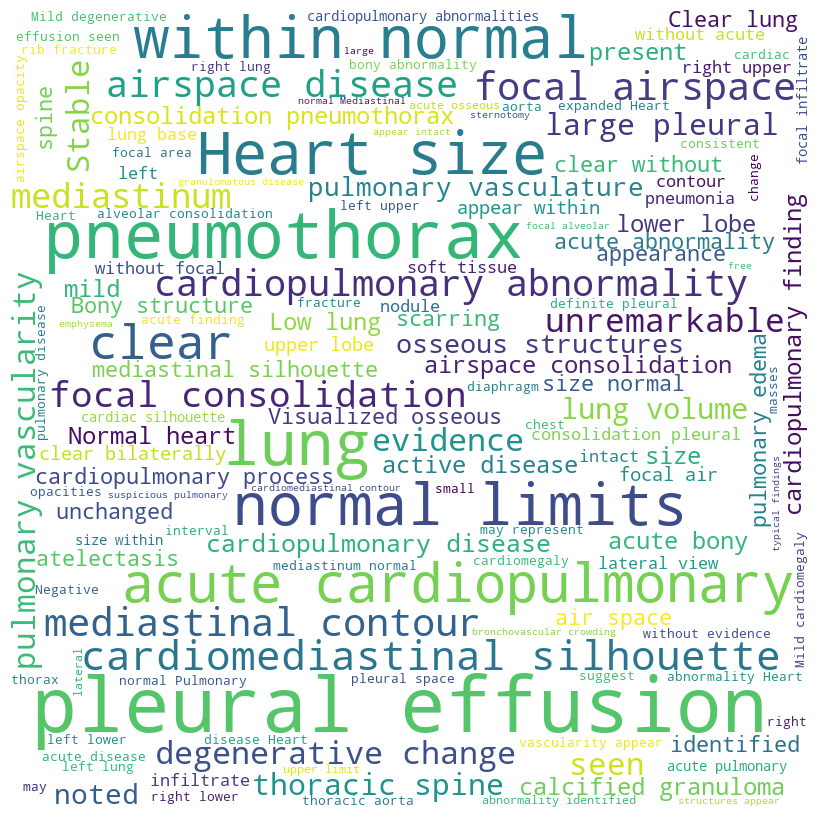

In [56]:
# Combine 'findings' and 'impressions' columns into a single text
combined_text = ' '.join(merged_df['findings'].fillna('') + ' ' + merged_df['impression'].fillna(''))


# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      min_font_size=10).generate(combined_text)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 

plt.show()

## Analysis on Problems Vs Impression

In [52]:
# Replace NaN values with empty strings ('') in 'Problems' and 'Impression' columns
merged_df['Problems'].fillna('', inplace=True)
merged_df['impression'].fillna('', inplace=True)
 
# Extract 'Problems' and 'Impression' columns
problems = merged_df['Problems']
impression = merged_df['impression']
 
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
 
# Transform 'Problems' and 'Impression' text data into TF-IDF vectors
problems_tfidf = vectorizer.fit_transform(problems)
impression_tfidf = vectorizer.transform(impression)
 
# Calculate cosine similarity between 'Problems' and 'Impression'
cosine_similarities = cosine_similarity(problems_tfidf, impression_tfidf)
 
# Calculate the mean cosine similarity
mean_similarity = cosine_similarities.mean()
print("Mean Cosine Similarity:", mean_similarity)
 
# Perform a one-sample t-test on the mean cosine similarity
null_hypothesis_mean = 0  # Null hypothesis: No significant correlation
t_statistic, p_values = ttest_1samp(cosine_similarities.mean(axis=1), null_hypothesis_mean)
 
# Check the mean p-value against alpha
alpha = 0.05  # Set your significance level
if p_values < alpha:
    print("There is a significant correlation between 'Problems' and 'Impression'.")
else:
    print("There is no significant correlation between 'Problems' and 'Impression'.")

Mean Cosine Similarity: 0.03116678458262353
There is a significant correlation between 'Problems' and 'Impression'.


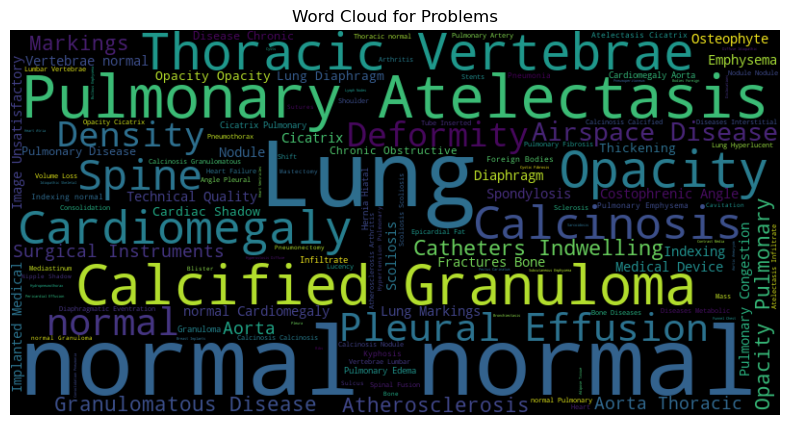

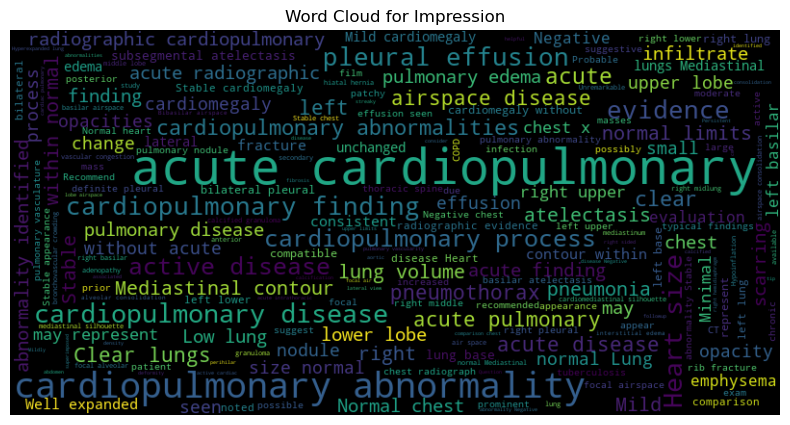

In [53]:
# Create a word cloud for 'Problems'
problems_wordcloud = WordCloud(width=800, height=400).generate(' '.join(problems))
plt.figure(figsize=(10, 5))
plt.imshow(problems_wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Problems")
plt.axis('off')
plt.show()
 
# Create a word cloud for 'Impression'
impression_wordcloud = WordCloud(width=800, height=400).generate(' '.join(impression))
plt.figure(figsize=(10, 5))
plt.imshow(impression_wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Impression")
plt.axis('off')
plt.show()

## Co-Occurence Analysis

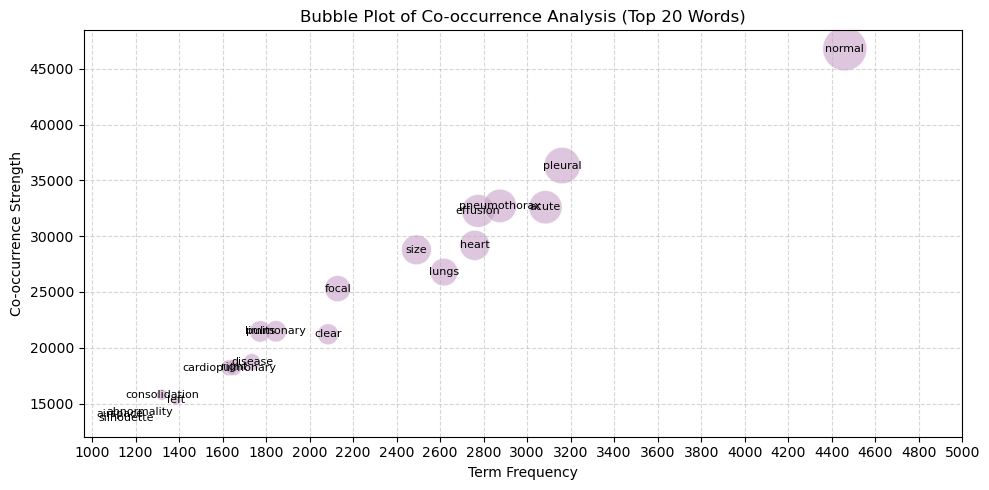

In [54]:
# Concatenate 'findings' and 'impression' columns into a single text column
merged_df['text'] = merged_df['findings'] + ' ' + merged_df['impression']
 
# Create a CountVectorizer to build the co-occurrence matrix (top 75 words)
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(merged_df['text'])
 
# Compute co-occurrence matrix
co_occurrence_matrix = (X.T * X)
co_occurrence_matrix.setdiag(0)  # Set diagonal values to 0 (self-co-occurrence)
 
# Extract term names and term frequencies
term_names = vectorizer.get_feature_names_out()
term_frequencies = X.sum(axis=0).A1
 
# Create a DataFrame for bubble plot
bubble_df = pd.DataFrame({'Term': term_names, 'Frequency': term_frequencies})
 
# Calculate co-occurrence strength between terms
co_occurrence_strengths = [co_occurrence_matrix[vectorizer.vocabulary_[term], :].sum() for term in bubble_df['Term']]
bubble_df['Co-occurrence Strength'] = co_occurrence_strengths
 
# Concatenate 'findings' and 'impression' columns into a single text column
merged_df['text'] = merged_df['findings'] + ' ' + merged_df['impression']
 
# Create a CountVectorizer to build the co-occurrence matrix (top 75 words)
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(merged_df['text'])
 
# Compute co-occurrence matrix
co_occurrence_matrix = (X.T * X)
co_occurrence_matrix.setdiag(0)  # Set diagonal values to 0 (self-co-occurrence)
 
# Extract term names and term frequencies
term_names = vectorizer.get_feature_names_out()
term_frequencies = X.sum(axis=0).A1
 
# Create a DataFrame for bubble plot
bubble_df = pd.DataFrame({'Term': term_names, 'Frequency': term_frequencies})
 
# Calculate co-occurrence strength between terms
co_occurrence_strengths = [co_occurrence_matrix[vectorizer.vocabulary_[term], :].sum() for term in bubble_df['Term']]
bubble_df['Co-occurrence Strength'] = co_occurrence_strengths
 
# Scale bubble size based on co-occurrence strength
min_strength = min(co_occurrence_strengths)
max_strength = max(co_occurrence_strengths)
# Scale the bubble sizes more significantly
max_bubble_size = 1000  # You can adjust this value
bubble_df['Bubble Size'] = (bubble_df['Co-occurrence Strength'] - min_strength) / (max_strength - min_strength) * max_bubble_size

 
# Create the bubble plot for the top 75 words
plt.figure(figsize=(10, 5))  # Increase plot size for better visibility
scatter = plt.scatter(bubble_df['Frequency'], bubble_df['Co-occurrence Strength'], s=bubble_df['Bubble Size'],
                      color='#C8A2C8', alpha=0.6, edgecolors="w", linewidth=0.5)

plt.title('Bubble Plot of Co-occurrence Analysis (Top 20 Words)')
plt.xlabel('Term Frequency')
plt.ylabel('Co-occurrence Strength')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([1000, 1200, 1400, 1600,1800,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,4200,4400,4600,4800,5000])  # Customize as needed
 
# Annotate bubbles with term names
for i, term in enumerate(bubble_df['Term']):
    plt.text(bubble_df['Frequency'][i], bubble_df['Co-occurrence Strength'][i], term,
             ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()


## K-Means Clustering

/Users/jayat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/jayat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/jayat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/jayat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'a

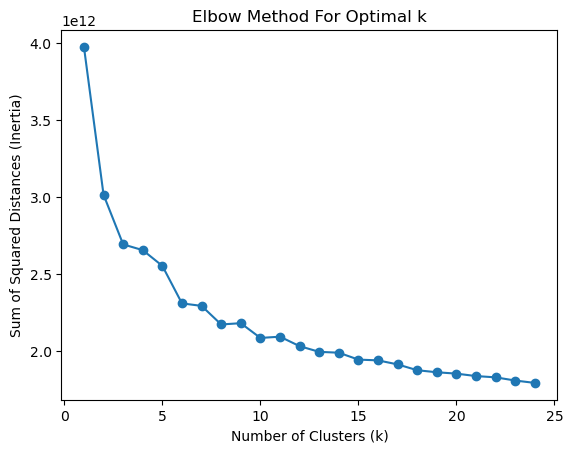

In [57]:
# Finding the cluster size through elbow curve

# Convert the list of image arrays into a 2D array
X = np.array(images).reshape(len(images), -1)

# Choose a range of k values
k_values = range(1, 25)

# Sum of squared distances for each k
inertia_values = []

for k in k_values:
    # Use MiniBatchKMeans for faster computation
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, max_iter=100)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

In [11]:
# Preprocess and extract features as before
N_CLUSTERS = 15  

# Initialize VGG16 model for feature extraction
model = VGG16(weights='imagenet', include_top=False)

# Preprocess images for VGG16 model
processed_images = np.array(images)
processed_images = preprocess_input(processed_images)

# Feature extraction
features = model.predict(processed_images)
features_flattened = features.reshape(features.shape[0], -1)

# Clustering
N_CLUSTERS = 15  # Adjust as necessary
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(features_flattened)

# Print cluster information
for i in range(N_CLUSTERS):
    print(f"\nImages in Cluster {i}:")
    cluster_indices = np.where(cluster_labels == i)[0]
    for index in cluster_indices:
        print(filenames[index])

234/234 [==============================] - 675s 3s/step


/Users/jayat/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Images in Cluster 0:
2842_IM-1254-1002.dcm.png
632_IM-2213-1002.dcm.png
1966_IM-0629-1002.dcm.png
1806_IM-0524-1003.dcm.png
2416_IM-0961-1002.dcm.png
1305_IM-0199-1002.dcm.png
3764_IM-1884-1002.dcm.png
443_IM-2078-1002.dcm.png
1788_IM-0513-1002.dcm.png
112_IM-0080-1002.dcm.png
612_IM-2199-2001.dcm.png
1746_IM-0489-1002.dcm.png
3531_IM-1726-1002.dcm.png
2263_IM-0853-4001.dcm.png
1207_IM-0140-0001-0001.dcm.png
2610_IM-1101-1002.dcm.png
2456_IM-0989-2001.dcm.png
758_IM-2309-2001.dcm.png
3953_IM-2021-1002.dcm.png
1335_IM-0215-1002.dcm.png
3688_IM-1839-0001-0002.dcm.png
1494_IM-0319-3001.dcm.png
3363_IM-1616-1002.dcm.png
2359_IM-0923-2001.dcm.png
2586_IM-1083-1003.dcm.png
2482_IM-1011-0001-0001.dcm.png
903_IM-2409-1002.dcm.png
1517_IM-0335-1002.dcm.png
1973_IM-0633-1002.dcm.png
341_IM-1648-1002.dcm.png
239_IM-0944-1002.dcm.png
1962_IM-0628-3003.dcm.png
3153_IM-1485-1002.dcm.png
3215_IM-1520-1003.dcm.png
3838_IM-1939-2001.dcm.png
3212_IM-1517-2001.dcm.png
2942_IM-1343-2001.dcm.png
2229_IM-0

In [12]:
# After clustering
unique_clusters = np.unique(cluster_labels)
print("Unique clusters found:", unique_clusters)

# Checking if any image is not assigned to a cluster
if -1 in unique_clusters:
    print("Some images are not assigned to any cluster.")
else:
    print("All images are properly clustered.")

Unique clusters found: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
All images are properly clustered.


## T-SNE Visualization for clusters

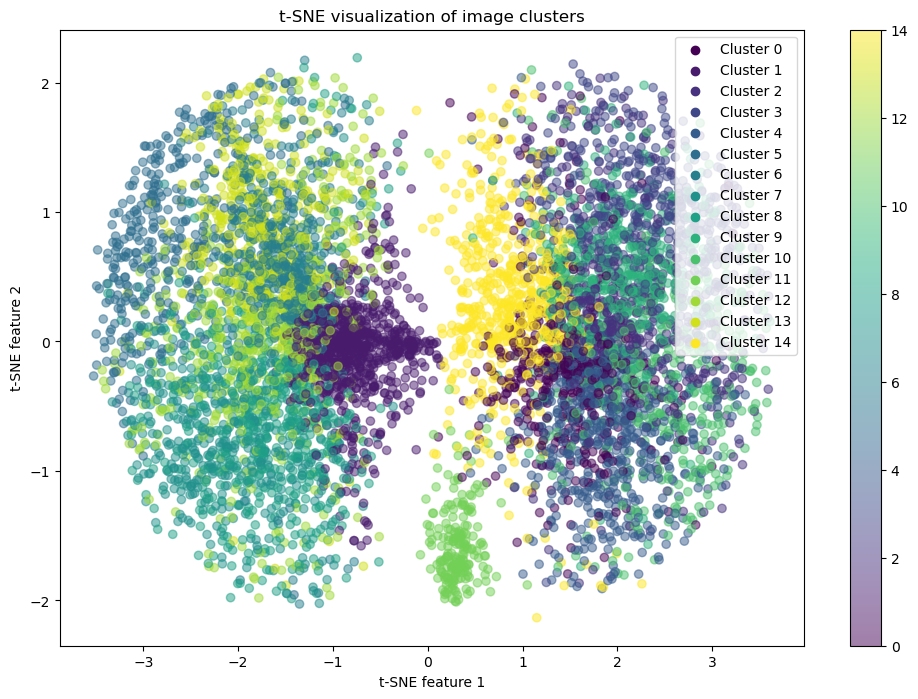

In [14]:
# Apply t-SNE to the features (assuming features_flattened and cluster_labels are already defined)
tsne = TSNE(n_components=2, perplexity=3000, random_state=42)
tsne_results = tsne.fit_transform(features_flattened)

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)

# Add a color bar for reference
plt.colorbar(scatter)

# Create a legend and place it in the upper right corner
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    plt.scatter([],[], color=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}')

plt.legend(loc='upper right')  # Position the legend in the upper right corner

# Label the plot
plt.title('t-SNE visualization of image clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Show the plot
plt.show()


In [29]:
filename_to_cluster = {filenames[i]: cluster_labels[i] for i in range(len(filenames))}

In [31]:
# Function to map a list of filenames to their clusters
def map_filenames_to_clusters(filenames):
    return [filename_to_cluster.get(f, -1) for f in filenames]

# Mapping each report to its corresponding clusters
merged_df['clusters'] = merged_df['filename'].apply(map_filenames_to_clusters)

In [33]:
merged_df['primary_cluster'] = merged_df['clusters'].apply(lambda x: x[0] if x else -1)

In [34]:
merged_df

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection_frontal,projection_lateral,caption,clusters,primary_cluster
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,"[1_IM-0001-4001.dcm.png, 1_IM-0001-3001.dcm.png]",[1_IM-0001-4001.dcm.png],[1_IM-0001-3001.dcm.png],The cardiac silhouette and mediastinum size ar...,"[5, 4]",5
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,"[2_IM-0652-1001.dcm.png, 2_IM-0652-2001.dcm.png]",[2_IM-0652-1001.dcm.png],[2_IM-0652-2001.dcm.png],Borderline cardiomegaly. Midline sternotomy . ...,"[8, 11]",8
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a , steps this . Pain to R ba...",,Borderline cardiomegaly. Midline sternotomy . ...,"No displaced rib fractures, pneumothorax, or p...","[3_IM-1384-1001.dcm.png, 3_IM-1384-2001.dcm.png]",[3_IM-1384-1001.dcm.png],[3_IM-1384-2001.dcm.png],Borderline cardiomegaly. Midline sternotomy . ...,"[5, 10]",5
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest , at hours",-year-old with .,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,"[4_IM-2050-1001.dcm.png, 4_IM-2050-2001.dcm.png]",[4_IM-2050-1001.dcm.png],[4_IM-2050-2001.dcm.png],There are diffuse bilateral interstitial and a...,"[5, 4]",5
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,"[5_IM-2117-1003002.dcm.png, 5_IM-2117-1004003....",[5_IM-2117-1003002.dcm.png],[5_IM-2117-1004003.dcm.png],The cardiomediastinal silhouette and pulmonary...,"[7, 2]",7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.",", .",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...,"[3995_IM-2046-1001.dcm.png, 3995_IM-2046-2001....",[3995_IM-2046-1001.dcm.png],[3995_IM-2046-2001.dcm.png],The cardiomediastinal silhouette and pulmonary...,"[8, 2]",8
3816,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,"[3996_IM-2047-1001.dcm.png, 3996_IM-2047-3001....",[3996_IM-2047-1001.dcm.png],[3996_IM-2047-3001.dcm.png],The lungs are clear. Heart size is normal. No ...,"[1, 0]",1
3817,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.","[3997_IM-2048-1001.dcm.png, 3997_IM-2048-1002....",[3997_IM-2048-1001.dcm.png],[3997_IM-2048-1002.dcm.png],"Heart size within normal limits. Small, nodula...","[7, 0]",7
3818,3998,normal,normal,"PA and lateral chest , comparison from",tuberculosis positive PPD,,"Heart size within normal limits. Small, nodula...",Heart size is normal and the lungs are clear.,"[3998_IM-2048-1001.dcm.png, 3998_IM-2048-1002....",[3998_IM-2048-1001.dcm.png],[3998_IM-2048-1002.dcm.png],"Heart size within normal limits. Small, nodula...","[7, 4]",7


## Text Sumarization

In [35]:
# Grouping reports by primary_cluster
grouped_reports = merged_df.groupby('primary_cluster')


In [37]:
from transformers import pipeline

# Using a lightweight model for summarization
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def summarize_reports(reports):
    if len(reports) == 0:
        return ""

    combined_text = ' '.join(reports)

    if len(combined_text.split()) < 30:  # If the report is very short
        return combined_text

    try:
        summary = summarizer(combined_text, max_length=130, min_length=30, truncation=True)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error during summarization: {e}")
        return combined_text

# Printing cluster Summary
for cluster, group in grouped_reports:
    reports = group['caption'].dropna().tolist()
    cluster_summary = summarize_reports(reports)
    print(f"Cluster {cluster} Summary:\n{cluster_summary}\n")

Cluster 0 Summary:
 There is persistent mild to moderate cardiomegaly . Multiple thoracic  deformities due to osteoporosis . No active disease. No acute pulmonary disease . No  pneumothorax . No destructive lesions of the ribs .

Cluster 1 Summary:
 Cardiomegaly with low lung volumes which are grossly clear . Low lung volumes with right basilar atelectasis . No acute cardiopulmonary abnormality identified . No active disease . No suspicious appearing lung nodules .

Cluster 2 Summary:
 Heart size borderline enlarged for technique, tracheostomy tube tip approximately 4.7 cm above the carina . Minimal degenerative changes of the thoracic spine . Mild bronchovascular crowding without typical findings of pulmonary edema .

Cluster 3 Summary:
 Left lower lobe, superior segment, airspace consolidation, radiographic appearance most typical for pneumonia . Left parapneumonic pleural effusion. No acute radiographic cardiopulmonary process. Stable appearance of pacemaker .

Cluster 4 Summary:
 H

## Identifying cluster for New Image and generating Caption/Summary

1/1 [==============================] - 0s 198ms/step


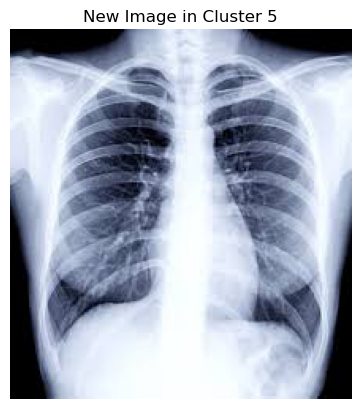


New Image belongs to Cluster 5
Cluster 5 Summary:
 No acute or active cardiac, pulmonary or pleural disease . No evidence of active disease . Bullous emphysema and interstitial fibrosis with no acute cardiopulmonary findings . Negative chest radiographs .



In [47]:
# Load the new image
new_image_path = '/Users/jayat/Desktop/images.jpg'  # Replace with the actual path to your image file
new_image = Image.open(new_image_path)

# Preprocess the image and extract features
new_image_array = preprocess_input(np.array(new_image.resize((224, 224))).reshape(1, 224, 224, 3))
new_image_features = model.predict(new_image_array)
new_image_features_flattened = new_image_features.reshape(1, -1)

# Predict the cluster label for the new image
new_image_cluster_label = kmeans.predict(new_image_features_flattened)[0]

# Display the image
plt.imshow(new_image)
plt.title(f"New Image in Cluster {new_image_cluster_label}")
plt.axis("off")
plt.show()

# Print the cluster information for the new image
print(f"\nNew Image belongs to Cluster {new_image_cluster_label}")

# Summarize reports for the new image cluster
new_image_reports = merged_df[merged_df['primary_cluster'] == new_image_cluster_label]['impression'].dropna().tolist()
new_image_cluster_summary = summarize_reports(new_image_reports)
print(f"Cluster {new_image_cluster_label} Summary:\n{new_image_cluster_summary}\n")


1/1 [==============================] - 0s 207ms/step


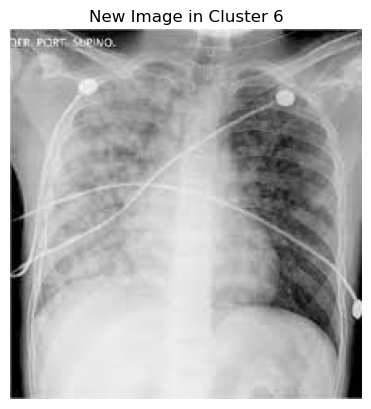


New Image belongs to Cluster 6
Cluster 6 Summary:
 The patient was diagnosed with pulmonary interstitial edema and bilateral pleural effusions . The patient had no active disease, no acute disease. No evidence of active disease . No signs of acute cardiopulmonary abnormalities .



In [49]:
# Load the new image
new_image_path = '/Users/jayat/Desktop/images1.jpg'  # Replace with the actual path to your image file
new_image = Image.open(new_image_path)

# Preprocess the image and extract features
new_image_array = preprocess_input(np.array(new_image.resize((224, 224))).reshape(1, 224, 224, 3))
new_image_features = model.predict(new_image_array)
new_image_features_flattened = new_image_features.reshape(1, -1)

# Predict the cluster label for the new image
new_image_cluster_label = kmeans.predict(new_image_features_flattened)[0]

# Display the image
plt.imshow(new_image)
plt.title(f"New Image in Cluster {new_image_cluster_label}")
plt.axis("off")
plt.show()

# Print the cluster information for the new image
print(f"\nNew Image belongs to Cluster {new_image_cluster_label}")

# Summarize reports for the new image cluster
new_image_reports = merged_df[merged_df['primary_cluster'] == new_image_cluster_label]['impression'].dropna().tolist()
new_image_cluster_summary = summarize_reports(new_image_reports)
print(f"Cluster {new_image_cluster_label} Summary:\n{new_image_cluster_summary}\n")